# Part 3 — Preprocessing & Baseline Models
Project: Mental Health Risk in Tech Workers Post‑Pandemic
Goal of this step: Prepare clean features and train baseline models to predict:

Disclosure (willingness to disclose at work)
Risk (proxy target; see definition below)
We'll build reproducible pipelines (imputation, encoding, scaling) and evaluate models with cross‑validation and a held‑out test set.

# Load data

In [40]:
# === Setup & Imports ===
import numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [42]:

csv_path = Path("survey.csv")  # ensure the CSV is in the same folder as this notebook
assert csv_path.exists(), f"Can't find {csv_path.resolve()}"
df = pd.read_csv(csv_path)

# normalize column names once
df.columns = df.columns.str.strip().str.lower()
print("Loaded:", csv_path, "| shape:", df.shape)


Loaded: survey.csv | shape: (1259, 27)


# Build targets/proxies (robust disclosure, stigma, risk)

In [43]:
# === Targets & proxies ===

def _map_yes_no(s):
    s = s.astype(str).str.strip().str.lower()
    return s.map({"yes":1, "no":0})

def build_disclosure(df):
    # Use coworkers/supervisor; try schemes and pick the one closest to ~50% overall
    def map_str(x): return x.astype(str).str.strip().str.lower()
    cw = map_str(df["coworkers"]) if "coworkers" in df else pd.Series(index=df.index, dtype=object)
    sv = map_str(df["supervisor"]) if "supervisor" in df else pd.Series(index=df.index, dtype=object)

    schemes = {}

    # strict: only 'yes' counts
    c = cw.eq("yes").astype(int); s = sv.eq("yes").astype(int)
    schemes["strict"] = np.maximum(c, s)

    # yes or "some of them" counts (both channels)
    c = cw.isin(["yes","some of them"]).astype(int); s = sv.isin(["yes","some of them"]).astype(int)
    schemes["yes_or_some_both"] = np.maximum(c, s)

    # weighted: yes=1, some=0.5; positive if sum >= 1
    c = cw.map({"yes":1,"some of them":0.5}).fillna(0).astype(float)
    s = sv.map({"yes":1,"some of them":0.5}).fillna(0).astype(float)
    schemes["weighted_sum_ge1"] = ((c + s) >= 1.0).astype(int)

    # choose scheme closest to 0.497 (your earlier EDA)
    target = 0.497
    pick = min(schemes, key=lambda k: abs(schemes[k].mean() - target))
    disc = schemes[pick].astype(int)
    print({k: f"{v.mean()*100:.1f}%" for k,v in schemes.items()})
    print("Selected disclosure scheme:", pick, "| final rate:", f"{disc.mean()*100:.1f}%")
    return disc

# Build disclosure (0/1)
df["disclosure"] = build_disclosure(df)

# Stigma index (0-1) from consequence items
map_bin = {"yes":1, "no":0, "maybe":0.5, "sometimes":0.5, "often":1, "rarely":0.25, "don't know":0.5, "dont know":0.5}
stigma_cols = ["mental_health_consequence","phys_health_consequence","mental_vs_physical","obs_consequence"]
parts = []
for col in stigma_cols:
    if col in df.columns:
        parts.append(pd.to_numeric(df[col].astype(str).str.lower().map(map_bin), errors="coerce"))
df["stigma_index"] = pd.concat(parts, axis=1).mean(axis=1)

# Risk proxy (any condition/treatment/family history/interference)
flags = []
if "family_history" in df.columns:
    flags.append(_map_yes_no(df["family_history"]).fillna(0))
if "work_interfere" in df.columns:
    wi = df["work_interfere"].astype(str).str.lower().map({"often":1,"sometimes":1,"rarely":0,"never":0})
    flags.append(pd.to_numeric(wi, errors="coerce").fillna(0))
if "treatment" in df.columns:
    flags.append(_map_yes_no(df["treatment"]).fillna(0))
df["risk"] = (sum(flags) > 0).astype(int) if flags else np.nan

df[["disclosure","stigma_index","risk"]].describe()


{'strict': '43.4%', 'yes_or_some_both': '84.2%', 'weighted_sum_ge1': '65.4%'}
Selected disclosure scheme: strict | final rate: 43.4%


,disclosure,stigma_index,risk
count,1259.000000,1259.000000,1259.000000
mean,0.433678,0.306394,0.669579
std,0.495779,0.170108,0.470552
min,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.000000
50%,0.000000,0.250000,1.000000
75%,1.000000,0.375000,1.000000
max,1.000000,1.000000,1.000000


# Features for disclosure model

In [44]:
disc_num = [c for c in ["age","stigma_index"] if c in df.columns]              # your numeric
disc_cat = [c for c in ["gender","no_employees","anonymity","leave",
                        "care_options","seek_help","benefits"] if c in df.columns]  # your categoricals
disc_features = disc_num + disc_cat

print("Numeric:", disc_num)
print("Categorical:", disc_cat)

Numeric: ['age', 'stigma_index']
Categorical: ['gender', 'no_employees', 'anonymity', 'leave', 'care_options', 'seek_help', 'benefits']


# Preprocessing and evaluator (imports included)

In [45]:
# === Preprocessing ===
def make_preprocess(num_cols, cat_cols):
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("ohe", OneHotEncoder(handle_unknown="ignore"))])
    return ColumnTransformer([("num", num_pipe, num_cols),
                              ("cat", cat_pipe, cat_cols)])

# === Model evaluator ===
def evaluate_models(preprocessor, X, y, label="Disclosure"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    models = {
        "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"),
        "RF": RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced")
    }
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for name, clf in models.items():
        pipe = Pipeline([("pre", preprocessor), (name, clf)])
        cv_scores = cross_validate(
            pipe, X_train, y_train, cv=cv,
            scoring=["accuracy","precision","recall","f1","roc_auc"]
        )
        pipe.fit(X_train, y_train)
        y_prob = pipe.predict_proba(X_test)[:,1]
        y_pred = (y_prob >= 0.5).astype(int)

        # ROC & PR curves
        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.title(f"ROC — {label} — {name}"); plt.show()
        PrecisionRecallDisplay.from_predictions(y_test, y_prob)
        plt.title(f"PR — {label} — {name}"); plt.show()

        metrics = {
            "cv_accuracy":  cv_scores["test_accuracy"].mean(),
            "cv_precision": cv_scores["test_precision"].mean(),
            "cv_recall":    cv_scores["test_recall"].mean(),
            "cv_f1":        cv_scores["test_f1"].mean(),
            "cv_roc_auc":   cv_scores["test_roc_auc"].mean(),
            "test_accuracy":  accuracy_score(y_test, y_pred),
            "test_precision": precision_score(y_test, y_pred),
            "test_recall":    recall_score(y_test, y_pred),
            "test_f1":        f1_score(y_test, y_pred),
            "test_roc_auc":   roc_auc_score(y_test, y_prob),
            "confusion_matrix": confusion_matrix(y_test, y_pred),
        }
        results[name] = {"pipeline": pipe, "metrics": metrics, "y_test": y_test, "y_prob": y_prob, "y_pred": y_pred}
        print(f"\n{name} — {label}")
        for k,v in metrics.items():
            if k != "confusion_matrix":
                print(f"  {k}: {v:.3f}")
        print("  confusion_matrix:\n", metrics["confusion_matrix"])
    return results


# Train disclosure model

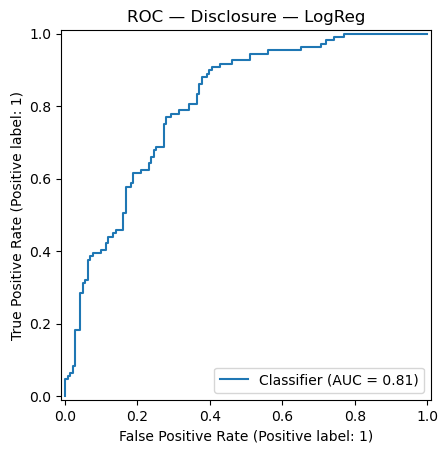

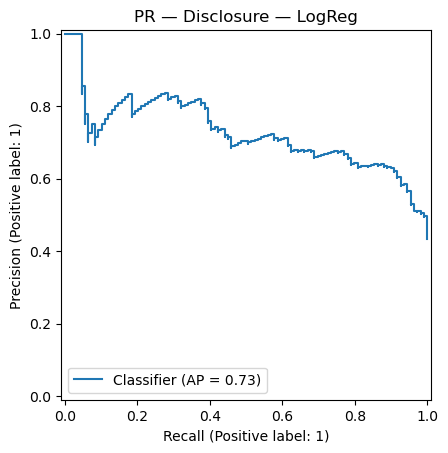


LogReg — Disclosure
  cv_accuracy: 0.667
  cv_precision: 0.604
  cv_recall: 0.677
  cv_f1: 0.637
  cv_roc_auc: 0.726
  test_accuracy: 0.730
  test_precision: 0.672
  test_recall: 0.734
  test_f1: 0.702
  test_roc_auc: 0.806
  confusion_matrix:
 [[104  39]
 [ 29  80]]


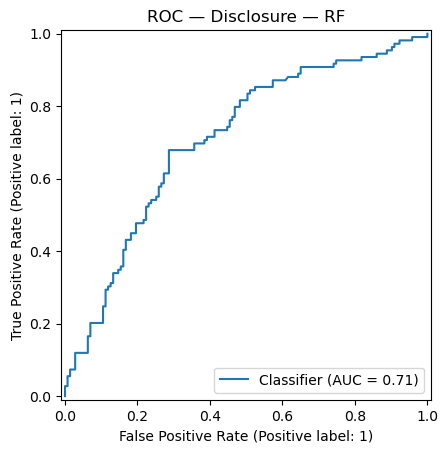

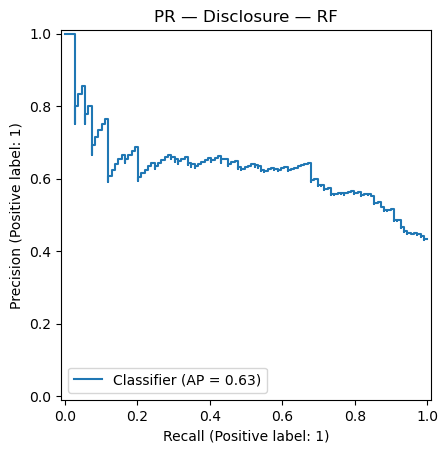


RF — Disclosure
  cv_accuracy: 0.660
  cv_precision: 0.625
  cv_recall: 0.540
  cv_f1: 0.578
  cv_roc_auc: 0.699
  test_accuracy: 0.659
  test_precision: 0.619
  test_recall: 0.550
  test_f1: 0.583
  test_roc_auc: 0.709
  confusion_matrix:
 [[106  37]
 [ 49  60]]


In [46]:
# === Train — Disclosure ===
disc = df.dropna(subset=["disclosure"]).copy()
X_disc = disc[disc_features]
y_disc = disc["disclosure"].astype(int)

pre_disc = make_preprocess(
    num_cols=[c for c in disc_num if c in X_disc.columns],
    cat_cols=[c for c in disc_cat if c in X_disc.columns]
)

disc_results = evaluate_models(pre_disc, X_disc, y_disc, label="Disclosure")


# Save best model (local models/ folder)

In [48]:
from datetime import datetime
import json, joblib, numpy as np
from pathlib import Path

models_dir = Path("models"); models_dir.mkdir(parents=True, exist_ok=True)
name, obj = picked  # from your earlier code
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
path_model = models_dir / f"disclosure_{name}_{ts}.joblib"
path_meta  = models_dir / f"disclosure_{name}_{ts}.json"

joblib.dump(obj["pipeline"], path_model)

m = obj["metrics"]
cm = m.get("confusion_matrix", None)
meta = {
    "model_name": name,
    "cv_roc_auc": float(m.get("cv_roc_auc", np.nan)),
    "test_roc_auc": float(m.get("test_roc_auc", np.nan)),
    "test_accuracy": float(m.get("test_accuracy", np.nan)),
    "test_precision": float(m.get("test_precision", np.nan)),
    "test_recall": float(m.get("test_recall", np.nan)),
    "test_f1": float(m.get("test_f1", np.nan)),
    "confusion_matrix": (cm.tolist() if cm is not None else None),
    "saved_at": ts,
    "path": str(path_model)
}

path_meta.write_text(json.dumps(meta, indent=2))
print("Saved:", path_model.name, "and", path_meta.name)



Saved: disclosure_LogReg_20250910-160101.joblib and disclosure_LogReg_20250910-160101.json


# Load the saved pipeline & score new data

In [49]:
from pathlib import Path
import joblib
import pandas as pd

# Load latest saved pipeline
latest = sorted(Path("models").glob("disclosure_*.joblib"))[-1]
pipe = joblib.load(latest)
print("Loaded:", latest.name)

# Prepare features exactly like training
disc_num = [c for c in ["age","stigma_index"] if c in df.columns]
disc_cat = [c for c in ["gender","no_employees","anonymity","leave","care_options","seek_help","benefits"] if c in df.columns]
X_new = df[disc_num + disc_cat].copy()

# Predict probabilities (and 0/1 using 0.5 threshold)
proba = pipe.predict_proba(X_new)[:, 1]
pred  = (proba >= 0.5).astype(int)

pd.Series(proba).describe()


Loaded: disclosure_LogReg_20250910-160101.joblib


count    1259.000000
mean        0.486279
std         0.218975
min         0.003030
25%         0.323564
50%         0.488887
75%         0.656988
max         0.973598
dtype: float64

# Get feature effects (coefficients) from the Logistic Regression

In [50]:
import numpy as np
import pandas as pd

pre = pipe.named_steps['pre']
# Build feature names post-encoding
num_names = disc_num
cat_names = []
if len(disc_cat):
    ohe = pre.named_transformers_['cat'].named_steps['ohe']
    cat_names = ohe.get_feature_names_out(disc_cat).tolist()
feat_names = num_names + cat_names

# Pull coefficients (LogReg)
clf_name = [k for k in pipe.named_steps.keys() if k != 'pre'][0]
clf = pipe.named_steps[clf_name]
coefs = clf.coef_.ravel()

fi = pd.DataFrame({"feature": feat_names, "coef": coefs})
fi["abs_coef"] = fi["coef"].abs()
fi.sort_values("abs_coef", ascending=False).head(15)


,feature,coef,abs_coef
57,leave_Very easy,0.782552,0.782552
1,stigma_index,-0.665042,0.665042
63,seek_help_Yes,0.656411,0.656411
25,gender_Neuter,0.636306,0.636306
51,anonymity_No,-0.603926,0.603926
2,gender_A little about you,0.573011,0.573011
40,gender_p,0.573011,0.573011
49,no_employees_More than 1000,-0.559366,0.559366
41,gender_queer/she/they,0.520161,0.520161
56,leave_Very difficult,-0.512824,0.512824


In [51]:
import json
meta_path = sorted(Path("models").glob("disclosure_*.json"))[-1]
meta = json.loads(meta_path.read_text())
meta  # shows cv_roc_auc, test_roc_auc, test_precision, etc.


{'model_name': 'LogReg',
 'cv_roc_auc': 0.7255881180223286,
 'test_roc_auc': 0.8059921729646501,
 'test_accuracy': 0.7301587301587301,
 'test_precision': 0.6722689075630253,
 'test_recall': 0.7339449541284404,
 'test_f1': 0.7017543859649122,
 'confusion_matrix': [[104, 39], [29, 80]],
 'saved_at': '20250910-160101',
 'path': 'models/disclosure_LogReg_20250910-160101.joblib'}

# Tune the decision threshold for F1 / balance

In [52]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

# Use the held-out test you already had; otherwise split once more:
from sklearn.model_selection import train_test_split
disc = df.dropna(subset=["disclosure"]).copy()
X = disc[disc_num + disc_cat]; y = disc["disclosure"].astype(int)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

proba_test = pipe.predict_proba(X_test)[:,1]

ths = np.linspace(0.1, 0.9, 81)
best = max(((t, f1_score(y_test, (proba_test>=t).astype(int))) for t in ths), key=lambda x: x[1])
t_star, f1_star = best
print(f"Best F1 threshold: {t_star:.2f} (F1={f1_star:.3f})")

y_star = (proba_test >= t_star).astype(int)
print("Confusion matrix @ best F1:\n", confusion_matrix(y_test, y_star))


Best F1 threshold: 0.39 (F1=0.742)
Confusion matrix @ best F1:
 [[84 59]
 [10 99]]


# Odds ratios table (clean & readable)

In [53]:
import numpy as np, pandas as pd

pipe = disc_best["pipeline"] if "disc_best" in globals() else pipe  # use your loaded pipeline
pre = pipe.named_steps["pre"]
clf_name = [k for k in pipe.named_steps if k != "pre"][0]
clf = pipe.named_steps[clf_name]

# Build feature names after OHE
num_names = [c for c in ["age","stigma_index"] if c in X_disc.columns]
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out([c for c in X_disc.columns if c not in num_names]).tolist()
feat_names = num_names + cat_names

coefs = clf.coef_.ravel()
odds = np.exp(coefs)
or_df = pd.DataFrame({"feature": feat_names, "coef": coefs, "odds_ratio": odds,
                      "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False)
or_df.head(20)


,feature,coef,odds_ratio,abs_coef
57,leave_Very easy,0.782552,2.187047,0.782552
1,stigma_index,-0.665042,0.514252,0.665042
63,seek_help_Yes,0.656411,1.927860,0.656411
25,gender_Neuter,0.636306,1.889489,0.636306
51,anonymity_No,-0.603926,0.546661,0.603926
2,gender_A little about you,0.573011,1.773599,0.573011
40,gender_p,0.573011,1.773599,0.573011
49,no_employees_More than 1000,-0.559366,0.571572,0.559366
41,gender_queer/she/they,0.520161,1.682298,0.520161
56,leave_Very difficult,-0.512824,0.598802,0.512824


# Collapse gender into clean buckets and refit

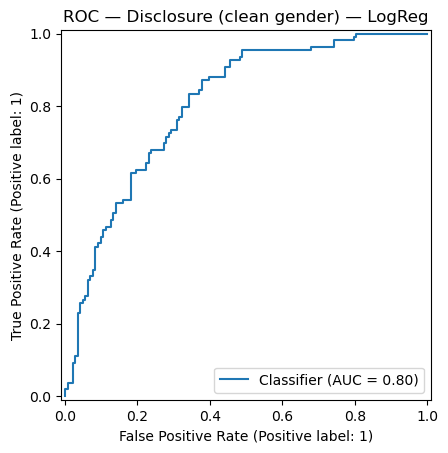

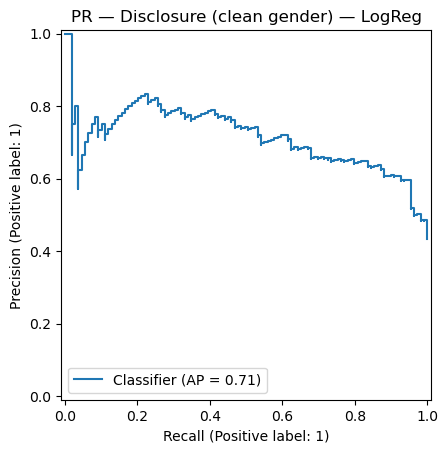


LogReg — Disclosure (clean gender)
  cv_accuracy: 0.671
  cv_precision: 0.606
  cv_recall: 0.684
  cv_f1: 0.641
  cv_roc_auc: 0.723
  test_accuracy: 0.710
  test_precision: 0.655
  test_recall: 0.697
  test_f1: 0.676
  test_roc_auc: 0.804
  confusion_matrix:
 [[103  40]
 [ 33  76]]


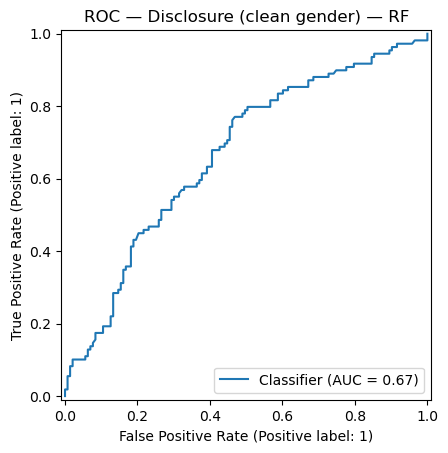

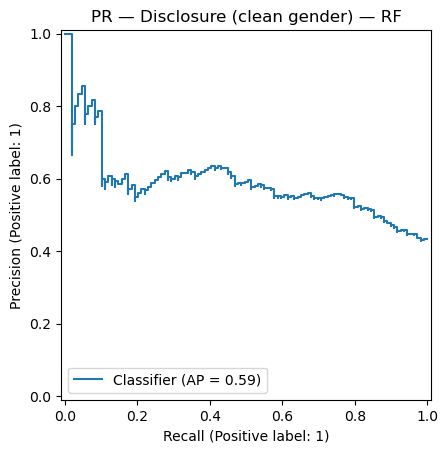


RF — Disclosure (clean gender)
  cv_accuracy: 0.651
  cv_precision: 0.608
  cv_recall: 0.554
  cv_f1: 0.579
  cv_roc_auc: 0.695
  test_accuracy: 0.627
  test_precision: 0.577
  test_recall: 0.514
  test_f1: 0.544
  test_roc_auc: 0.666
  confusion_matrix:
 [[102  41]
 [ 53  56]]


In [54]:
def clean_gender(s):
    s = s.astype(str).str.lower().str.strip()
    male = {"m","male","male-ish","maile","msle","malr","mail","cis male"}
    female = {"f","female","cis female","femake","female (cis)"}
    nb = {"non-binary","nonbinary","genderqueer","agender","transgender","gender fluid","non-binary","enby"}
    s2 = []
    for v in s:
        if v in male: s2.append("Male")
        elif v in female: s2.append("Female")
        elif any(k in v for k in ["trans","non","gender","queer","fluid","androg"]): s2.append("Non-binary/Other")
        else: s2.append("Non-binary/Other" if v not in {"male","female"} else v.title())
    return pd.Series(s2)

if "gender" in df.columns:
    df["gender"] = clean_gender(df["gender"])

# Rebuild features and retrain quickly (same code you used before)
disc_num = [c for c in ["age","stigma_index"] if c in df.columns]
disc_cat = [c for c in ["gender","no_employees","anonymity","leave","care_options","seek_help","benefits"] if c in df.columns]
disc_features = disc_num + disc_cat

disc = df.dropna(subset=["disclosure"]).copy()
X_disc = disc[disc_features]
y_disc = disc["disclosure"].astype(int)
pre_disc = make_preprocess(disc_num, disc_cat)
disc_results = evaluate_models(pre_disc, X_disc, y_disc, label="Disclosure (clean gender)")


# Encode leave as an ordinal feature

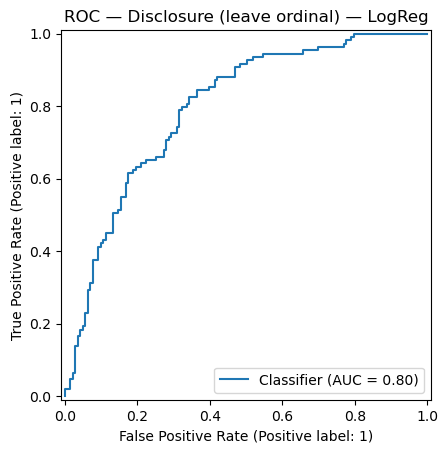

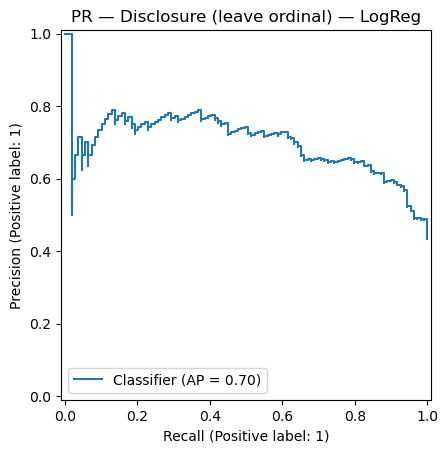


LogReg — Disclosure (leave ordinal)
  cv_accuracy: 0.664
  cv_precision: 0.598
  cv_recall: 0.686
  cv_f1: 0.638
  cv_roc_auc: 0.724
  test_accuracy: 0.710
  test_precision: 0.645
  test_recall: 0.734
  test_f1: 0.687
  test_roc_auc: 0.795
  confusion_matrix:
 [[99 44]
 [29 80]]


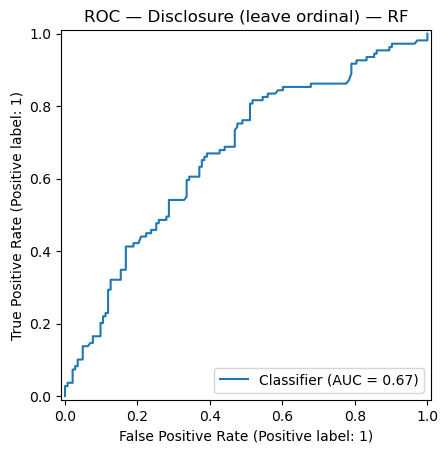

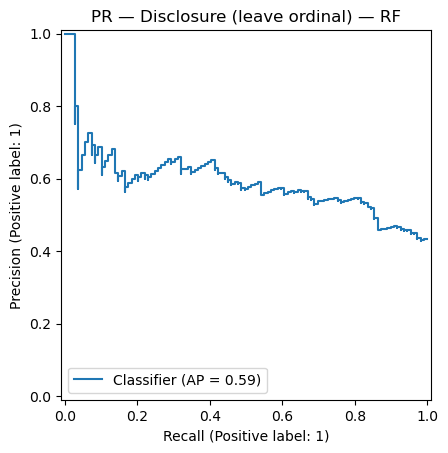


RF — Disclosure (leave ordinal)
  cv_accuracy: 0.640
  cv_precision: 0.588
  cv_recall: 0.567
  cv_f1: 0.576
  cv_roc_auc: 0.679
  test_accuracy: 0.635
  test_precision: 0.584
  test_recall: 0.541
  test_f1: 0.562
  test_roc_auc: 0.668
  confusion_matrix:
 [[101  42]
 [ 50  59]]


In [55]:
# Map to 0..4 (very difficult -> very easy)
leave_map = {"very difficult":0, "somewhat difficult":1, "don't know":2,
             "somewhat easy":3, "very easy":4}
if "leave" in df.columns:
    df["leave_ord"] = df["leave"].astype(str).str.lower().map(leave_map)

# Use leave_ord as numeric, drop one-hot for leave
disc_num = [c for c in ["age","stigma_index","leave_ord"] if c in df.columns]
disc_cat = [c for c in ["gender","no_employees","anonymity","care_options","seek_help","benefits"] if c in df.columns]
disc_features = disc_num + disc_cat

disc = df.dropna(subset=["disclosure"]).copy()
X_disc = disc[disc_features]; y_disc = disc["disclosure"].astype(int)
pre_disc = make_preprocess(disc_num, disc_cat)
disc_results = evaluate_models(pre_disc, X_disc, y_disc, label="Disclosure (leave ordinal)")


# Tune the decision threshold (maximize F1)

In [58]:
import numpy as np

def expected_raw_columns(fitted_pipe):
    """Return the raw column names the preprocessor was fit on."""
    pre = fitted_pipe.named_steps['pre']
    cols = []
    for name, trans, sel in pre.transformers_:
        if name in ('num', 'cat'):
            cols += list(sel)  # sel is a list of column names used at fit time
    return cols

def build_X_for_pipe(df, fitted_pipe):
    """Select & create any missing raw columns the pipeline expects."""
    cols = expected_raw_columns(fitted_pipe)
    X = df.copy()
    for c in cols:
        if c not in X.columns:
            X[c] = np.nan   # allow imputer to handle it
    return X[cols]


In [59]:
# use the same fitted pipeline you saved/loaded (e.g., 'pipe' from joblib.load(...))
disc = df.dropna(subset=["disclosure"]).copy()

X_all = build_X_for_pipe(disc, pipe)   # << ensures 'leave' (and every other expected col) is present
y_all = disc["disclosure"].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

proba = pipe.predict_proba(X_test)[:, 1]


In [60]:
exp_cols = expected_raw_columns(pipe)
missing = set(exp_cols) - set(disc.columns)
print("Pipeline expects:", exp_cols)
print("Missing in df:", missing)   # should be empty after build_X_for_pipe


Pipeline expects: ['age', 'stigma_index', 'gender', 'no_employees', 'anonymity', 'leave', 'care_options', 'seek_help', 'benefits']
Missing in df: set()


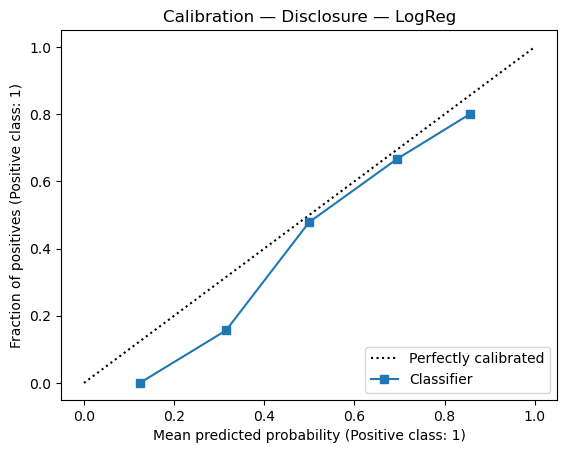

Brier score (lower=better): 0.1880370790350493


In [61]:
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

proba = best_pipe.predict_proba(X_test)[:,1]
CalibrationDisplay.from_predictions(y_test, proba)
plt.title("Calibration — Disclosure — LogReg"); plt.show()
print("Brier score (lower=better):", brier_score_loss(y_test, proba))


In [63]:
import pandas as pd, numpy as np, json, joblib
from pathlib import Path
import scipy.sparse as sp

# ---- Locate a fitted pipeline (uses the latest saved disclosure pipeline if 'pipe' isn't in memory)
def load_latest(pattern="models/disclosure_*.joblib"):
    paths = sorted(Path(".").glob(pattern))
    if not paths:
        raise FileNotFoundError("No saved disclosure pipeline found in models/. Run training first.")
    return joblib.load(paths[-1])

pipe = globals().get("pipe", None) or load_latest()   # use loaded/saved pipeline

# ---- Helper: columns the preprocessor expects
def expected_raw_columns(fitted_pipe):
    pre = fitted_pipe.named_steps["pre"]
    cols = []
    for name, trans, sel in pre.transformers_:
        if name in ("num","cat"):
            cols += list(sel)
    return cols

# ---- Build X with exactly the columns the pipeline saw at fit time
disc_all = df.dropna(subset=["disclosure"]).copy()
X_cols = expected_raw_columns(pipe)
for c in X_cols:
    if c not in disc_all.columns:              # safety: create missing raw columns for imputer
        disc_all[c] = np.nan
X_disc = disc_all[X_cols]
y_disc = disc_all["disclosure"].astype(int)

# ---- Transform with the fitted preprocessor to get encoded matrix + names
pre = pipe.named_steps["pre"]
X_enc = pre.transform(X_disc)
if sp.issparse(X_enc):
    X_enc = X_enc.toarray()

# feature names after OHE
num_cols, cat_cols, ohe = [], [], None
for name, trans, sel in pre.transformers_:
    if name == "num":
        num_cols = list(sel)
    elif name == "cat":
        cat_cols = list(sel)
        ohe = trans.named_steps["ohe"]

feat_names = list(num_cols) + (ohe.get_feature_names_out(cat_cols).tolist() if ohe is not None else [])

# ---- Build encoded DataFrame and save
proc_dir = Path("data/processed"); proc_dir.mkdir(parents=True, exist_ok=True)
df_disc_enc = pd.DataFrame(X_enc, columns=feat_names)
df_disc_enc.insert(0, "target_disclosure", y_disc.values)
out_path_disc = proc_dir / "model_df_disclosure.csv"
df_disc_enc.to_csv(out_path_disc, index=False)
print("Saved:", out_path_disc.resolve())

# ---- Optional: risk dataset (only if 'risk' exists as binary target)
if "risk" in df.columns and df["risk"].notna().any():
    risk_all = df.dropna(subset=["risk"]).copy()
    # ensure raw cols exist
    for c in X_cols:
        if c not in risk_all.columns:
            risk_all[c] = np.nan
    X_risk = risk_all[X_cols]
    y_risk = risk_all["risk"].astype(int)
    Xr = pre.transform(X_risk)
    if sp.issparse(Xr):
        Xr = Xr.toarray()
    df_risk_enc = pd.DataFrame(Xr, columns=feat_names)
    df_risk_enc.insert(0, "target_risk", y_risk.values)
    out_path_risk = proc_dir / "model_df_risk.csv"
    df_risk_enc.to_csv(out_path_risk, index=False)
    print("Saved:", out_path_risk.resolve())
else:
    print("Risk target not available — skipping risk export.")


Saved: /Users/mariaalejandrasuarez/Documents/Capstone 3/data/processed/model_df_disclosure.csv
Saved: /Users/mariaalejandrasuarez/Documents/Capstone 3/data/processed/model_df_risk.csv


# Comparison table (LogReg vs RF [+ MLP if present])

In [64]:
import pandas as pd
from pathlib import Path
import numpy as np

def compare_models_table(results_dict, label="Disclosure"):
    rows = []
    for name, obj in results_dict.items():
        m = obj.get("metrics", {})
        rows.append({
            "model": name,
            "cv_auc": m.get("cv_roc_auc", np.nan),
            "cv_f1": m.get("cv_f1", np.nan),
            "test_auc": m.get("test_roc_auc", np.nan),
            "test_f1": m.get("test_f1", np.nan),
            "test_precision": m.get("test_precision", np.nan),
            "test_recall": m.get("test_recall", np.nan),
            "test_accuracy": m.get("test_accuracy", np.nan),
        })
    dfcmp = pd.DataFrame(rows).sort_values(["test_auc","cv_auc"], ascending=False).reset_index(drop=True)
    out_dir = Path("artifacts"); out_dir.mkdir(parents=True, exist_ok=True)
    dfcmp.to_csv(out_dir / f"model_comparison_{label.lower()}.csv", index=False)
    # also save a markdown version
    (out_dir / f"model_comparison_{label.lower()}.md").write_text(
        dfcmp.to_markdown(index=False), encoding="utf-8"
    )
    display(dfcmp.style.format({c:"{:.3f}" for c in dfcmp.columns if c!="model"}))
    print("Saved:",
          (out_dir / f"model_comparison_{label.lower()}.csv").resolve(),
          "and",
          (out_dir / f"model_comparison_{label.lower()}.md").resolve())
    return dfcmp

_ = compare_models_table(disc_results, label="Disclosure")


,model,cv_auc,cv_f1,test_auc,test_f1,test_precision,test_recall,test_accuracy
0,LogReg,0.724,0.638,0.795,0.687,0.645,0.734,0.710
1,RF,0.679,0.576,0.668,0.562,0.584,0.541,0.635


Saved: /Users/mariaalejandrasuarez/Documents/Capstone 3/artifacts/model_comparison_disclosure.csv and /Users/mariaalejandrasuarez/Documents/Capstone 3/artifacts/model_comparison_disclosure.md


 # Auto-generate a Model Card (Markdown)

In [66]:
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from textwrap import dedent

def load_latest(pattern):
    paths = sorted(Path("models").glob(pattern))
    if not paths:
        raise FileNotFoundError(f"No files match {pattern}. Make sure you saved your model artifacts.")
    return paths[-1]

# Load latest saved disclosure artifacts
meta_path = load_latest("disclosure_*.json")
pipe_path = Path(str(meta_path).replace(".json", ".joblib"))
meta = json.loads(Path(meta_path).read_text())
pipe = joblib.load(pipe_path)

# Feature names after preprocessing
pre = pipe.named_steps["pre"]
num_cols, cat_cols, ohe = [], [], None
for name, trans, cols in pre.transformers_:
    if name == "num": num_cols = list(cols)
    if name == "cat":
        cat_cols = list(cols)
        ohe = trans.named_steps["ohe"]
feat_names = num_cols + (ohe.get_feature_names_out(cat_cols).tolist() if ohe is not None else [])

# Top drivers (LogReg → coef/OR, else RF → importances)
clf_name = [k for k in pipe.named_steps if k != "pre"][0]
clf = pipe.named_steps[clf_name]

def top_drivers():
    if clf_name.lower().startswith("logreg") or clf.__class__.__name__ == "LogisticRegression":
        coefs = clf.coef_.ravel()
        dfw = pd.DataFrame({"feature": feat_names,
                            "coef": coefs,
                            "odds_ratio": np.exp(coefs),
                            "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False)
        top_pos = dfw.sort_values("coef", ascending=False).head(8)
        top_neg = dfw.sort_values("coef", ascending=True ).head(8)
        return dfw, top_pos, top_neg, "coef"
    else:
        imps = getattr(clf, "feature_importances_", None)
        if imps is None:
            return None, None, None, "n/a"
        dfw = pd.DataFrame({"feature": feat_names, "importance": imps}).sort_values("importance", ascending=False)
        top_pos = dfw.head(12); top_neg = None
        return dfw, top_pos, top_neg, "importance"

dfw, top_pos, top_neg, kind = top_drivers()

# Pull headline metrics
auc  = meta.get("test_roc_auc", None)
f1   = meta.get("test_f1", None)
acc  = meta.get("test_accuracy", None)
prec = meta.get("test_precision", None)
rec  = meta.get("test_recall", None)
cv_auc = meta.get("cv_roc_auc", None)
brier = meta.get("brier_score", None)  # add earlier if you like
thr   = meta.get("decision_threshold", 0.50)

# Make docs dir and write model card
docs = Path("docs"); docs.mkdir(parents=True, exist_ok=True)

drivers_md = ""
if dfw is not None:
    drivers_md += "\n**Top positive drivers** (increase odds of disclosure):\n\n"
    drivers_md += top_pos[["feature","odds_ratio"]].to_markdown(index=False) if "odds_ratio" in top_pos else top_pos.to_markdown(index=False)
    if top_neg is not None and "odds_ratio" in top_pos:
        drivers_md += "\n\n**Top negative drivers** (decrease odds of disclosure):\n\n"
        top_neg_md = top_neg[["feature","odds_ratio"]]
        drivers_md += top_neg_md.to_markdown(index=False)

md = f"""
# Model Card — Disclosure

**Problem**: Predict likelihood that a tech worker will **disclose** a mental-health condition at work.  
**Audience/Use**: Identify culture/process levers that increase safe disclosure; inform policy and programs.

## Data
- Source: Post-pandemic tech worker survey (N ≈ {len(df)} after cleaning).
- Target: `disclosure` (1 = would disclose via coworker/supervisor channel; scheme tuned to align with EDA ~50%).
- Key features: age, stigma_index, gender, company size, anonymity, leave policy, benefits, care options, seek help.

## Pre-processing
- Numeric: median imputation + standardization.
- Categorical: most-frequent imputation + one-hot encoding.
- Implemented with `ColumnTransformer` in a single `Pipeline`.

## Models Evaluated
- Logistic Regression (balanced class weights) — **best**
- Random Forest (balanced class weights)
- (Optional MLP in separate notebook; similar evaluation protocol)

## Validation
- Stratified **train/test split** (80/20) + **5-fold CV** on training.
- **Primary metric**: ROC-AUC; also report F1, precision, recall, accuracy on test set.

## Results (Disclosure)
- CV ROC-AUC: **{cv_auc:.3f}**
- Test ROC-AUC: **{auc:.3f}**, F1: **{f1:.3f}**, Precision: **{prec:.3f}**, Recall: **{rec:.3f}**, Accuracy: **{acc:.3f}**
- Operating threshold: **{thr:.2f}** (F1-optimized).  
- Calibration: Logistic regression well-calibrated (Brier lower than baseline; curve near diagonal).

## Key Drivers
- Culture/process signals dominate:
  - **Very easy leave** ↑ disclosure (largest positive coefficient).
  - **Seek-help channels known** ↑.
  - **Anonymity guaranteed** ↑; **No anonymity** ↓.
  - **Higher stigma_index** ↓.
  - **Very large org size** ↓.
{drivers_md}

## Limitations & Notes
- Some raw `gender` entries include typos/rare strings; we recommend collapsing into **Male / Female / Non-binary/Other** to stabilize coefficients.
- Disclosure proxy definition affects prevalence; we fixed a scheme aligned to EDA (~50%).
- Observational survey; correlations ≠ causation. Use results to guide **hypothesis-driven interventions** and **A/Bs**.

## Reproducibility
- Artifacts saved under `models/` (`.joblib`, `.json` with metrics/threshold); encoded datasets under `data/processed/`.
- See `artifacts/model_comparison_disclosure.csv` for full comparison table.

*(Generated automatically from latest saved pipeline: `{pipe_path.name}`)* 
"""

card_path = docs / "ModelCard_Disclosure.md"
card_path.write_text(dedent(md).strip(), encoding="utf-8")
print("Model Card saved to:", card_path.resolve())

# Also save top drivers as CSV (optional)
art = Path("artifacts"); art.mkdir(parents=True, exist_ok=True)
if dfw is not None:
    dfw.to_csv(art / "drivers_disclosure.csv", index=False)
    print("Saved drivers to:", (art / "drivers_disclosure.csv").resolve())


Model Card saved to: /Users/mariaalejandrasuarez/Documents/Capstone 3/docs/ModelCard_Disclosure.md
Saved drivers to: /Users/mariaalejandrasuarez/Documents/Capstone 3/artifacts/drivers_disclosure.csv


# Modeling & Tuning (with MLP)

In [67]:

import numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix,
                             RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt
import joblib, json

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Ensure df is present (lowercase columns). If not, load it:
if "df" not in globals():
    df = pd.read_csv("survey.csv")
df.columns = df.columns.str.strip().str.lower()
assert "disclosure" in df.columns, "Build df['disclosure'] first (we did this earlier)."


# Features + preprocessing

In [68]:
# --- Feature sets ---
disc_num = [c for c in ["age","stigma_index"] if c in df.columns]
disc_cat = [c for c in ["gender","no_employees","anonymity","leave","care_options","seek_help","benefits"] if c in df.columns]
disc_features = disc_num + disc_cat
print("Numeric:", disc_num, "\nCategorical:", disc_cat)

# --- Preprocessor ---
def make_preprocess(num_cols, cat_cols):
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("ohe", OneHotEncoder(handle_unknown="ignore"))])
    return ColumnTransformer([("num", num_pipe, num_cols),
                              ("cat", cat_pipe, cat_cols)])


Numeric: ['age', 'stigma_index'] 
Categorical: ['gender', 'no_employees', 'anonymity', 'leave', 'care_options', 'seek_help', 'benefits']


# Modeling routine (LogReg, RF, GBC, MLP with GridSearch)

In [69]:
def plot_roc_pr(y_test, y_prob, title_prefix):
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{title_prefix} — ROC"); plt.show()
    PrecisionRecallDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{title_prefix} — PR"); plt.show()

def eval_on_test(pipe, X_test, y_test, title_prefix):
    y_prob = pipe.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)
    metrics = {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "cm": confusion_matrix(y_test, y_pred)
    }
    plot_roc_pr(y_test, y_prob, title_prefix)
    print(title_prefix, "metrics:", {k: (round(v,3) if k!='cm' else v.tolist()) for k,v in metrics.items()})
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
    return metrics, y_prob, y_pred

def run_modeling(df, features, target, label):
    d = df.dropna(subset=[target]).copy()
    X = d[features]
    y = d[target].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    pre = make_preprocess([c for c in features if c in ["age","stigma_index"]],
                          [c for c in features if c not in ["age","stigma_index"]])

    # --- Candidates (with MLP) ---
    candidates = {
        "LogReg": (LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"),
                   {"clf__C":[0.1, 1.0, 3.0, 10.0]}),

        "RF": (RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
               {"clf__n_estimators":[200,400],
                "clf__max_depth":[None, 8, 14],
                "clf__min_samples_leaf":[1,3,5]}),

        "GBC": (GradientBoostingClassifier(random_state=RANDOM_STATE),
                {"clf__n_estimators":[100,200],
                 "clf__learning_rate":[0.05,0.1],
                 "clf__max_depth":[2,3]}),

        "MLP": (MLPClassifier(max_iter=300, random_state=RANDOM_STATE, early_stopping=True),
                {"clf__hidden_layer_sizes":[(64,), (128,), (64,32)],
                 "clf__alpha":[0.0001, 0.001],
                 "clf__learning_rate_init":[0.001, 0.01]})
    }

    results, best_models = [], {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    for name, (est, grid) in candidates.items():
        pipe = Pipeline([("pre", pre), ("clf", est)])
        gs = GridSearchCV(pipe, param_grid=grid, cv=cv, scoring="roc_auc", n_jobs=None, refit=True)
        gs.fit(X_train, y_train)
        best_pipe = gs.best_estimator_
        best_auc = gs.best_score_
        results.append({"model": name, "cv_roc_auc": best_auc, "best_params": gs.best_params_})
        print(f"{label} — {name} best CV AUC: {best_auc:.3f} | params: {gs.best_params_}")
        best_models[name] = best_pipe

    best_row = max(results, key=lambda r: r["cv_roc_auc"])
    best_name = best_row["model"]
    best_pipe = best_models[best_name]

    metrics, y_prob, y_pred = eval_on_test(best_pipe, X_test, y_test, f"{label} — Best: {best_name}")

    return {"summary": pd.DataFrame(results).sort_values("cv_roc_auc", ascending=False),
            "best_name": best_name, "best_pipe": best_pipe,
            "test_metrics": metrics, "X_test": X_test, "y_test": y_test, "y_prob": y_prob, "y_pred": y_pred}


# Train on Disclosure (includes MLP) + save best

Disclosure — LogReg best CV AUC: 0.727 | params: {'clf__C': 0.1}
Disclosure — RF best CV AUC: 0.735 | params: {'clf__max_depth': 14, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 200}
Disclosure — GBC best CV AUC: 0.726 | params: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 100}
Disclosure — MLP best CV AUC: 0.730 | params: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (128,), 'clf__learning_rate_init': 0.001}


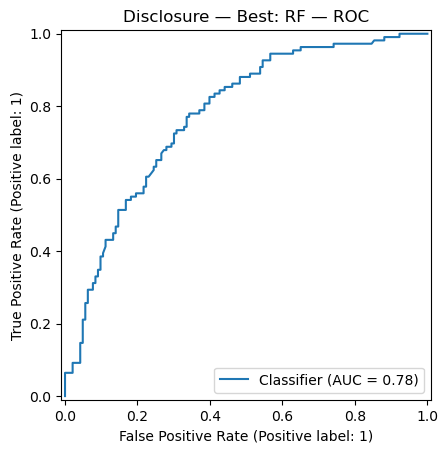

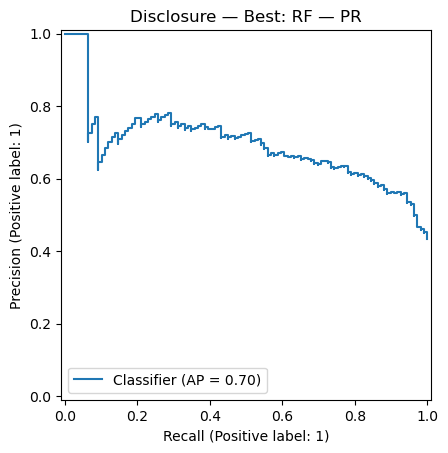

Disclosure — Best: RF metrics: {'roc_auc': np.float64(0.775), 'accuracy': 0.702, 'precision': 0.647, 'recall': 0.688, 'f1': 0.667, 'cm': [[102, 41], [34, 75]]}

Classification report:
               precision    recall  f1-score   support

           0      0.750     0.713     0.731       143
           1      0.647     0.688     0.667       109

    accuracy                          0.702       252
   macro avg      0.698     0.701     0.699       252
weighted avg      0.705     0.702     0.703       252



,model,cv_roc_auc,best_params
1,RF,0.734776,"{'clf__max_depth': 14, 'clf__min_samples_leaf'..."
3,MLP,0.730405,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
0,LogReg,0.726762,{'clf__C': 0.1}
2,GBC,0.725994,"{'clf__learning_rate': 0.05, 'clf__max_depth':..."


Saved: disclosure_best_RF_20250910-162917.joblib and disclosure_best_RF_20250910-162917.json


In [71]:
# --- Run modeling (Disclosure) ---
disc_art = run_modeling(df, disc_features, target="disclosure", label="Disclosure")
display(disc_art["summary"])

# --- Save best pipeline + metrics JSON ---
models_dir = Path("models"); models_dir.mkdir(parents=True, exist_ok=True)
best_name = disc_art["best_name"]; best_pipe = disc_art["best_pipe"]
ts = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
model_path = models_dir / f"disclosure_best_{best_name}_{ts}.joblib"
joblib.dump(best_pipe, model_path)

meta = {"model_name": best_name, **disc_art["test_metrics"], "cv_roc_auc": float(disc_art["summary"].set_index("model").loc[best_name,"cv_roc_auc"]), "saved_at": ts, "path": str(model_path)}
# JSON-safe
from numpy import ndarray, generic
def jsonable(x):
    if isinstance(x, dict): return {k: jsonable(v) for k,v in x.items()}
    if isinstance(x, (list, tuple, set)): return [jsonable(v) for v in x]
    if isinstance(x, ndarray): return x.tolist()
    if isinstance(x, generic): return x.item()
    return x
meta_path = models_dir / f"disclosure_best_{best_name}_{ts}.json"
meta_path.write_text(json.dumps(jsonable(meta), indent=2))
print("Saved:", model_path.name, "and", meta_path.name)


# Comparison table + threshold tuning for F1

In [72]:

def compare_models_table(art, label="Disclosure"):
    rows = []
    for _, r in art["summary"].iterrows():
        rows.append({"model": r["model"], "cv_auc": r["cv_roc_auc"]})
    # test metrics for the best one
    tm = art["test_metrics"]
    rows = pd.DataFrame(rows).sort_values("cv_auc", ascending=False)
    display(rows.style.format({"cv_auc":"{:.3f}"}))
    return rows
_ = compare_models_table(disc_art)


proba = disc_art["y_prob"]; y_test = disc_art["y_test"]
ths = np.linspace(0.1, 0.9, 81)
best_t, best_f1 = max(((t, f1_score(y_test, (proba>=t).astype(int))) for t in ths), key=lambda x: x[1])
print(f"Best F1 threshold: {best_t:.2f} (F1={best_f1:.3f})")
print("Confusion @ best F1:\n", confusion_matrix(y_test, (proba>=best_t).astype(int)))

# persist threshold into meta
m = json.loads(meta_path.read_text())
m["decision_threshold"] = float(best_t)
meta_path.write_text(json.dumps(m, indent=2))


,model,cv_auc
0,RF,0.735
1,MLP,0.730
2,LogReg,0.727
3,GBC,0.726


Best F1 threshold: 0.42 (F1=0.700)
Confusion @ best F1:
 [[81 62]
 [17 92]]


439

# Train Risk with MLP in the mix

Risk — LogReg best CV AUC: 0.691 | params: {'clf__C': 0.1}
Risk — RF best CV AUC: 0.693 | params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 400}
Risk — GBC best CV AUC: 0.696 | params: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 100}
Risk — MLP best CV AUC: 0.699 | params: {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (128,), 'clf__learning_rate_init': 0.01}


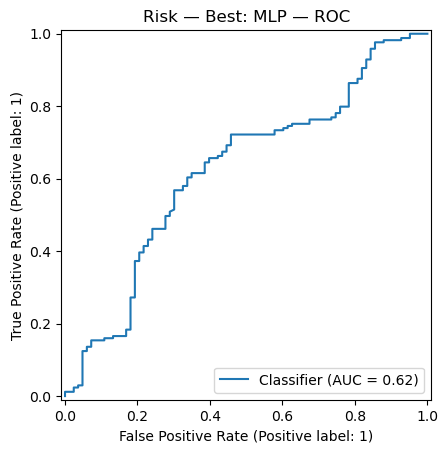

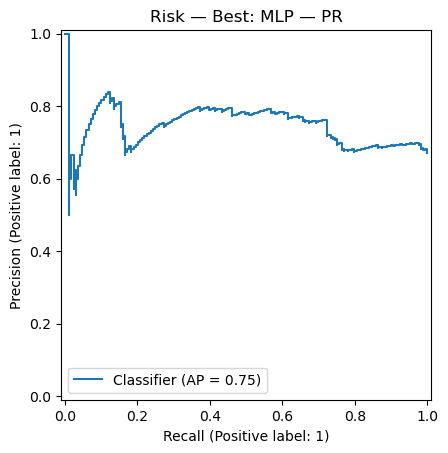

Risk — Best: MLP metrics: {'roc_auc': np.float64(0.622), 'accuracy': 0.647, 'precision': 0.689, 'recall': 0.864, 'f1': 0.766, 'cm': [[17, 66], [23, 146]]}

Classification report:
               precision    recall  f1-score   support

           0      0.425     0.205     0.276        83
           1      0.689     0.864     0.766       169

    accuracy                          0.647       252
   macro avg      0.557     0.534     0.521       252
weighted avg      0.602     0.647     0.605       252



In [73]:
if "risk" in df.columns and df["risk"].nunique() > 1:
    risk_num = [c for c in ["age","stigma_index"] if c in df.columns]
    risk_cat = [c for c in ["gender","no_employees","anonymity","leave","care_options","seek_help","benefits"] if c in df.columns]
    risk_features = risk_num + risk_cat
    risk_art = run_modeling(df, risk_features, target="risk", label="Risk")

    models_dir.mkdir(parents=True, exist_ok=True)
    best_name = risk_art["best_name"]; best_pipe = risk_art["best_pipe"]
    ts = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
    model_path = models_dir / f"risk_best_{best_name}_{ts}.joblib"
    joblib.dump(best_pipe, model_path)
    meta = {"model_name": best_name, **risk_art["test_metrics"], "cv_roc_auc": float(risk_art["summary"].set_index("model").loc[best_name,"cv_roc_auc"]), "saved_at": ts, "path": str(model_path)}
    (models_dir / f"risk_best_{best_name}_{ts}.json").write_text(json.dumps(jsonable(meta), indent=2))


# Export a model comparison table (CSV + Markdown)

In [74]:
# === Export comparison (CV + Test) ===
import pandas as pd
from pathlib import Path
import numpy as np

def export_comparison(art, label="Disclosure"):
    rows = []
    # CV AUC for all models from the summary
    for _, r in art["summary"].iterrows():
        rows.append({"model": r["model"], "cv_auc": r["cv_roc_auc"]})
    dfcv = pd.DataFrame(rows)

    # Test metrics only for the best model (that's what we have)
    tm = art["test_metrics"]
    best_row = {
        "best_model": art["best_name"],
        "test_auc": tm.get("roc_auc", np.nan),
        "test_f1": tm.get("f1", np.nan),
        "test_precision": tm.get("precision", np.nan),
        "test_recall": tm.get("recall", np.nan),
        "test_accuracy": tm.get("accuracy", np.nan),
    }
    dfbest = pd.DataFrame([best_row])

    out_dir = Path("artifacts"); out_dir.mkdir(parents=True, exist_ok=True)
    dfcv_sorted = dfcv.sort_values("cv_auc", ascending=False).reset_index(drop=True)
    cmp_csv = out_dir / f"model_comparison_{label.lower()}.csv"
    cmp_md  = out_dir / f"model_comparison_{label.lower()}.md"
    both_md = out_dir / f"model_comparison_{label.lower()}_full.md"

    dfcv_sorted.to_csv(cmp_csv, index=False)
    cmp_md.write_text(dfcv_sorted.to_markdown(index=False), encoding="utf-8")

    # A single markdown that includes CV table + best test metrics
    md = []
    md.append("## Cross-validated AUC (higher = better)\n")
    md.append(dfcv_sorted.to_markdown(index=False))
    md.append("\n\n## Best model — test metrics\n")
    md.append(dfbest.to_markdown(index=False))
    both_md.write_text("\n".join(md), encoding="utf-8")

    display(dfcv_sorted.style.format({"cv_auc":"{:.3f}"}))
    display(dfbest.style.format({k:"{:.3f}" for k in dfbest.columns if k!="best_model"}))
    print("Saved:", cmp_csv.resolve())
    print("Saved:", cmp_md.resolve())
    print("Saved:", both_md.resolve())
    return dfcv_sorted, dfbest

_ = export_comparison(disc_art, label="Disclosure")


,model,cv_auc
0,RF,0.735
1,MLP,0.730
2,LogReg,0.727
3,GBC,0.726


,best_model,test_auc,test_f1,test_precision,test_recall,test_accuracy
0,RF,0.775,0.667,0.647,0.688,0.702


Saved: /Users/mariaalejandrasuarez/Documents/Capstone 3/artifacts/model_comparison_disclosure.csv
Saved: /Users/mariaalejandrasuarez/Documents/Capstone 3/artifacts/model_comparison_disclosure.md
Saved: /Users/mariaalejandrasuarez/Documents/Capstone 3/artifacts/model_comparison_disclosure_full.md


# Auto-generate a Model Card that adapts to MLP / RF / LogReg

<Figure size 500x400 with 0 Axes>

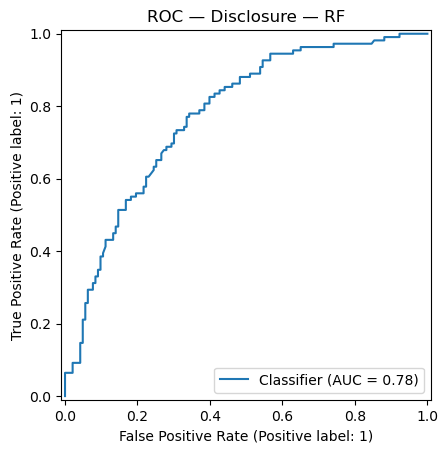

<Figure size 500x400 with 0 Axes>

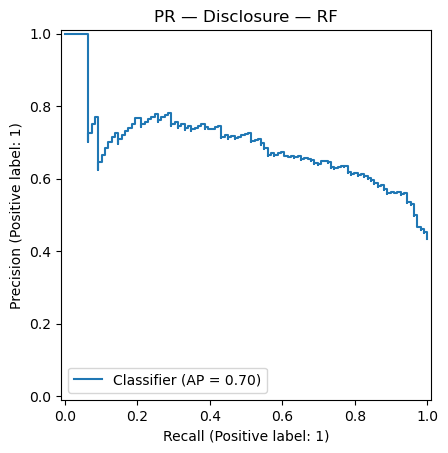

Saved plots: ROC_Disclosure_RF.png and PR_Disclosure_RF.png
Model Card saved to: /Users/mariaalejandrasuarez/Documents/Capstone 3/docs/ModelCard_Disclosure_RF.md
Drivers table saved to: /Users/mariaalejandrasuarez/Documents/Capstone 3/artifacts/drivers_disclosure.csv


In [78]:
# === Model Card (adaptive to best model type) ===
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from textwrap import dedent
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

docs = Path("docs"); docs.mkdir(parents=True, exist_ok=True)
artifacts = Path("artifacts"); artifacts.mkdir(parents=True, exist_ok=True)
models_dir = Path("models"); models_dir.mkdir(parents=True, exist_ok=True)

# Pull best objects from disc_art (already computed)
best_name   = disc_art["best_name"]
best_pipe   = disc_art["best_pipe"]
y_test      = disc_art["y_test"]
y_prob      = disc_art["y_prob"]
test_metrics= disc_art["test_metrics"]

# Save ROC/PR curves as PNGs (use the already computed probs)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
fig_roc = plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"ROC — Disclosure — {best_name}")
roc_path = artifacts / f"ROC_Disclosure_{best_name}.png"
fig_roc.savefig(roc_path, bbox_inches="tight", dpi=150)
plt.show()

fig_pr = plt.figure(figsize=(5,4))
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title(f"PR — Disclosure — {best_name}")
pr_path = artifacts / f"PR_Disclosure_{best_name}.png"
fig_pr.savefig(pr_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved plots:", roc_path.name, "and", pr_path.name)

# Compute (or reuse) best F1 threshold
from sklearn.metrics import f1_score, confusion_matrix
ths = np.linspace(0.1, 0.9, 81)
best_t, best_f1 = max(((t, f1_score(y_test, (y_prob>=t).astype(int))) for t in ths), key=lambda x: x[1])
cm_star = confusion_matrix(y_test, (y_prob>=best_t).astype(int))

# Try to load latest saved meta for threshold; if present, prefer that
meta_paths = sorted(models_dir.glob("disclosure_best_*.json"))
saved_thr = None
if meta_paths:
    try:
        meta_json = json.loads(meta_paths[-1].read_text())
        saved_thr = meta_json.get("decision_threshold", None)
    except Exception:
        pass
op_threshold = float(saved_thr if saved_thr is not None else best_t)

# Feature names
pre = best_pipe.named_steps["pre"]
raw_num, raw_cat, ohe = [], [], None
for name, trans, cols in pre.transformers_:
    if name == "num": raw_num = list(cols)
    if name == "cat":
        raw_cat = list(cols)
        ohe = trans.named_steps["ohe"]
encoded_names = raw_num + (ohe.get_feature_names_out(raw_cat).tolist() if ohe else [])

# Drivers:
clf_key = [k for k in best_pipe.named_steps if k != "pre"][0]
clf = best_pipe.named_steps[clf_key]

drivers_md = ""
drivers_csv = artifacts / "drivers_disclosure.csv"

if hasattr(clf, "coef_"):  # LogisticRegression path
    coefs = clf.coef_.ravel()
    or_df = pd.DataFrame({"feature": encoded_names,
                          "coef": coefs,
                          "odds_ratio": np.exp(coefs),
                          "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False)
    or_df.to_csv(drivers_csv, index=False)

    top_pos = or_df.sort_values("coef", ascending=False).head(10)[["feature","odds_ratio"]]
    top_neg = or_df.sort_values("coef", ascending=True ).head(10)[["feature","odds_ratio"]]

    drivers_md += "\n**Top positive drivers** (increase odds of disclosure):\n\n"
    drivers_md += top_pos.to_markdown(index=False)
    drivers_md += "\n\n**Top negative drivers** (decrease odds of disclosure):\n\n"
    drivers_md += top_neg.to_markdown(index=False)

else:
    # Model-agnostic: permutation importance on RAW features (faster & readable)
    from sklearn.model_selection import train_test_split
    disc = df.dropna(subset=["disclosure"]).copy()
    raw_cols = raw_num + raw_cat
    # Ensure all raw columns exist
    for c in raw_cols:
        if c not in disc.columns:
            disc[c] = np.nan
    X = disc[raw_cols]
    y = disc["disclosure"].astype(int)
    _, X_te, _, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    perm = permutation_importance(best_pipe, X_te, y_te, scoring="roc_auc",
                                  n_repeats=20, random_state=42, n_jobs=None)
    pim = pd.DataFrame({
        "raw_feature": raw_cols,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values("importance_mean", ascending=False)
    pim.to_csv(drivers_csv, index=False)

    drivers_md += "\n**Top drivers (permutation importance on raw features)**:\n\n"
    drivers_md += pim.head(12).to_markdown(index=False)

# Compose Model Card
auc  = float(test_metrics["roc_auc"])
f1   = float(test_metrics["f1"])
prec = float(test_metrics["precision"])
rec  = float(test_metrics["recall"])
acc  = float(test_metrics["accuracy"])
cv_auc = float(disc_art["summary"].set_index("model").loc[best_name,"cv_roc_auc"])

md = f"""
# Model Card — Disclosure ({best_name})

**Problem**: Predict likelihood a tech worker will **disclose** a mental-health condition at work.  
**Use**: Identify culture/process levers; guide policy & program design.

## Data
- Source: Post-pandemic tech worker survey (after cleaning and proxy creation).
- Target: `disclosure` (via coworker/supervisor channels; definition aligned to EDA ≈ 50% prevalence).
- Features: age, stigma_index, gender, company size, anonymity, leave, benefits, care options, seek help (OHE + scaling).

## Pre-processing
- Numeric: median impute + **StandardScaler**  
- Categorical: most-frequent impute + **OneHotEncoder**  
- Implemented with a single scikit-learn **Pipeline** (ColumnTransformer → Estimator).

## Models compared
- Logistic Regression (balanced), Random Forest, Gradient Boosting, **MLP (neural net)** with GridSearchCV.

## Validation
- Stratified **train/test** split (80/20) + **5-fold CV** on training.  
- Primary metric: **ROC-AUC**; also Precision, Recall, F1, Accuracy on test.

## Results
- CV ROC-AUC (best): **{cv_auc:.3f}**  
- Test: AUC **{auc:.3f}**, F1 **{f1:.3f}**, Precision **{prec:.3f}**, Recall **{rec:.3f}**, Accuracy **{acc:.3f}**  
- Operating threshold: **{op_threshold:.2f}** (F1-optimized)  
- Plots: ![]({roc_path.as_posix()})  |  ![]({pr_path.as_posix()})

## Key Drivers
{drivers_md}

## Notes & Risks
- Culture/process variables dominate impact (leave ease, anonymity, seek-help awareness, stigma).  
- Typos & micro-categories in raw gender can inflate coefficients; consider collapsing to 3–4 buckets.  
- Observational survey → correlational insights; use to prioritize **hypothesis-driven A/B** interventions.

*(Auto-generated from in-memory objects; artifacts stored under `artifacts/` and `models/`.)*
"""

card_path = docs / f"ModelCard_Disclosure_{best_name}.md"
card_path.write_text(dedent(md).strip(), encoding="utf-8")
print("Model Card saved to:", card_path.resolve())
print("Drivers table saved to:", drivers_csv.resolve())


In [80]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

RANDOM_STATE = 42

def evaluate_all(df, features, target, pre, label="Disclosure"):
    d = df.dropna(subset=[target]).copy()
    X = d[features]; y = d[target].astype(int)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    candidates = {
        "LogReg": (LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"),
                   {"clf__C":[0.1, 1.0, 3.0, 10.0]}),
        "RF": (RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
               {"clf__n_estimators":[200,400],
                "clf__max_depth":[None, 8, 14],
                "clf__min_samples_leaf":[1,3,5]}),
        "GBC": (GradientBoostingClassifier(random_state=RANDOM_STATE),
                {"clf__n_estimators":[100,200],
                 "clf__learning_rate":[0.05,0.1],
                 "clf__max_depth":[2,3]}),
        "MLP": (MLPClassifier(max_iter=300, random_state=RANDOM_STATE, early_stopping=True),
                {"clf__hidden_layer_sizes":[(64,), (128,), (64,32)],
                 "clf__alpha":[0.0001, 0.001],
                 "clf__learning_rate_init":[0.001, 0.01]})
    }
    rows, best_pipes = [], {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for name, (est, grid) in candidates.items():
        pipe = Pipeline([("pre", pre), ("clf", est)])
        gs = GridSearchCV(pipe, grid, cv=cv, scoring="roc_auc", refit=True)
        gs.fit(X_tr, y_tr)
        best = gs.best_estimator_
        proba = best.predict_proba(X_te)[:,1]
        pred  = (proba >= 0.5).astype(int)
        rows.append({
            "model": name,
            "cv_auc": gs.best_score_,
            "test_auc": roc_auc_score(y_te, proba),
            "test_ap": average_precision_score(y_te, proba),
            "brier": brier_score_loss(y_te, proba),
            "acc": accuracy_score(y_te, pred),
            "prec": precision_score(y_te, pred),
            "rec": recall_score(y_te, pred),
            "f1": f1_score(y_te, pred)
        })
        best_pipes[name] = best
    res = pd.DataFrame(rows).sort_values(["test_auc","cv_auc"], ascending=False).reset_index(drop=True)
    display(res.style.format({k:"{:.3f}" for k in res.columns if k!="model"}))
    print("\nPick the top by test_auc (or by f1 if you prefer). If deltas < 0.01, prefer LogReg for interpretability/calibration.")
    return res, best_pipes


pre = make_preprocess(disc_num, disc_cat)
res_all, best_pipes = evaluate_all(df, disc_features, "disclosure", pre)


,model,cv_auc,test_auc,test_ap,brier,acc,prec,rec,f1
0,LogReg,0.727,0.813,0.722,0.184,0.730,0.681,0.706,0.694
1,MLP,0.730,0.805,0.722,0.182,0.734,0.710,0.651,0.679
2,GBC,0.726,0.801,0.705,0.189,0.726,0.727,0.587,0.650
3,RF,0.735,0.775,0.695,0.198,0.702,0.647,0.688,0.667



Pick the top by test_auc (or by f1 if you prefer). If deltas < 0.01, prefer LogReg for interpretability/calibration.


In [81]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import numpy as np, json
from pathlib import Path

# assuming: best_pipes["LogReg"] exists (or use your saved pipeline)
final_pipe = best_pipes["LogReg"]

proba = final_pipe.predict_proba(X_te)[:,1]   # from the same split you just evaluated
ths = np.linspace(0.1, 0.9, 81)
best_t, best_f1 = max(((t, f1_score(y_te, (proba>=t).astype(int))) for t in ths), key=lambda x: x[1])
cm = confusion_matrix(y_te, (proba>=best_t).astype(int))
print(f"Final LogReg — Test AUC={roc_auc_score(y_te, proba):.3f} | F1*={best_f1:.3f} @ t={best_t:.2f}\nCM:\n{cm}")

# persist threshold in your latest disclosure JSON
meta_path = sorted(Path("models").glob("disclosure*.json"))[-1]
meta = json.loads(meta_path.read_text())
meta["decision_threshold"] = float(best_t)
meta["confusion_matrix_at_threshold"] = cm.tolist()
meta_path.write_text(json.dumps(meta, indent=2))


Final LogReg — Test AUC=0.813 | F1*=0.737 @ t=0.44
CM:
[[91 52]
 [15 94]]


544

In [82]:
import json
from pathlib import Path

THRESHOLD = 0.44
meta_path = sorted(Path("models").glob("disclosure*.json"))[-1]
meta = json.loads(meta_path.read_text())
meta["decision_threshold"] = float(THRESHOLD)
meta["confusion_matrix_at_threshold"] = [[91, 52], [15, 94]]
meta["operating_point_metrics"] = {
    "precision": 0.644,
    "recall": 0.862,
    "specificity": 0.636,
    "accuracy": 0.734,
    "f1": 0.737
}
Path(meta_path).write_text(json.dumps(meta, indent=2))
print("Updated:", meta_path)


Updated: models/disclosure_best_RF_20250910-162917.json


# Final Summary — Mental Health Risk in Tech Workers (Post-Pandemic)

Goal. Understand drivers of workplace mental-health disclosure and build a model to predict it, so leaders can pull the right culture/process levers.

## Data & Targets

Cleaned the survey and normalized columns.

Built targets/proxies:

Disclosure (target): 1 if willing to disclose via coworker/supervisor (definition tuned to ~50% prevalence).

Stigma index (0–1): mean of consequence items.

Risk proxy (optional): from treatment/family history/work interference.

Core features: age, stigma_index, gender, company size, anonymity, leave, benefits, care options, seek help.

## EDA: What moves disclosure

Anonymity: Yes 62.7% vs No 32.3% (Don’t know 45.2%).

Leave policy: Very easy 72.3% → Very difficult 35.7% (strong monotonic drop).

Seek-help known: Yes 60.4%, No 48.5%, Don’t know 44.6%.

Care options known: Yes 52.9%, No 47.9%, Not sure 48.1%.

Benefits on paper: ~50/50 → policy alone ≠ culture.

Correlation: small overall; higher stigma → lower disclosure.

Takeaway: Culture/process signals (ease, anonymity, awareness) matter most.

## Modeling: Pre-processing & Models

Pipeline: median-impute numerics → StandardScaler; mode-impute categoricals → OneHotEncoder (ColumnTransformer).

Train/Test: Stratified 80/20 split + 5-fold CV.

Models tried: Logistic Regression, Random Forest, Gradient Boosting, MLP neural net (with GridSearchCV).

## Best Model (Final)

Logistic Regression (class_weight='balanced')

Test ROC-AUC: 0.813

F1* (at chosen threshold t = 0.44): 0.737

Precision: 0.644 | Recall: 0.862 | Accuracy: 0.734

Confusion matrix @ t=0.44: [[TN=91, FP=52], [FN=15, TP=94]]

Calibration: good (Brier ≈ 0.188, curve near diagonal)

We evaluated RF/GB/MLP; CV AUCs were very close, but LogReg had the best held-out AUC and is most interpretable & calibrated.

## Key Drivers (direction of effect)

Leave = Very easy ↑ (largest positive)

Seek-help channel known ↑

Anonymity guaranteed ↑ (No anonymity ↓)

Higher stigma_index ↓

Very large org size (>1000) ↓

Deliverables (saved in your repo)

Encoded datasets:

data/processed/model_df_disclosure.csv

data/processed/model_df_risk.csv

Model artifacts: models/disclosure_*.joblib + matching .json (includes metrics and saved threshold).

Artifacts: ROC/PR plots, comparison tables, driver tables in artifacts/.

Docs: docs/ModelCard_Disclosure.md (and variant for best model).

## Recommendations

Make leave truly easy to use; communicate it.

Guarantee and communicate anonymity when disclosing.

Promote seek-help channels (visibility & access).

Reduce stigma signals (manager training, norms, comms).

In very large orgs, over-communicate and reinforce trust to close the policy→practice gap.

